In [42]:
import utils_sleepasandroid as us
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# from collections import namedtuple
# import pendulum
import numpy as np
from scipy.signal import savgol_filter as savgol_filter
# import pathlib

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# First we'll parse one record from the Sleep as Android backup file

In [3]:
# Read in the Sleep as Android data and print some of the headers
SA_data = 'sample_data/SleepAsAndroid_data.csv'
sa_file_as_list = us.read_sleepasandroid_file(SA_data)
sa_file_as_list[0][0:15]

['Id',
 'Tz',
 'From',
 'To',
 'Sched',
 'Hours',
 'Rating',
 'Comment',
 'Framerate',
 'Snore',
 'Noise',
 'Cycles',
 'DeepSleep',
 'LenAdjust',
 'Geo']

In [4]:
# Parse the first record
ridx  = 0
split_record = us.split_sleepasandroid_record(sa_file_as_list, ridx)

# Print the awake records to get an idea of the data
split_record._fields

C:\ProgramData\Anaconda3\lib\site-packages\pendulum\pendulum.py:483: PendulumDeprecationWarning: The create() helper will no longer exist in version 2.0. Use datetime() instead.
  return cls.create(**actual_parts)


('start_datetime',
 'end_datetime',
 'record_start_ms',
 'record_end_ms',
 'light_sleep',
 'deep_sleep',
 'rem_sleep',
 'awake',
 'heart_rate',
 'hr_zone',
 'noise_events',
 'alarms',
 'timezone')

In [5]:
# what time zone is this record in?
split_record.timezone

'America/Edmonton'

## Now we'll take the parsed record and create records for each sleep stage

In [6]:
sleep_record, ls_record, ds_record, awake_record = us.parse_sleep_records(split_record)

In [7]:
sleep_record.stage

array(['LightSleep', 'DeepSleep', 'LightSleep', 'Awake', 'DeepSleep',
       'LightSleep', 'DeepSleep', 'LightSleep', 'DeepSleep', 'LightSleep',
       'DeepSleep', 'LightSleep', 'DeepSleep', 'LightSleep', 'DeepSleep',
       'LightSleep', 'Awake', 'DeepSleep', 'LightSleep', 'Awake',
       'DeepSleep', 'LightSleep', 'DeepSleep', 'LightSleep', 'Awake',
       'Awake'], dtype=object)

In [8]:
ls_record.cycle_start_time

[<Pendulum [2018-05-19T01:59:21.716000-06:00]>,
 <Pendulum [2018-05-19T02:34:21.716000-06:00]>,
 <Pendulum [2018-05-19T03:49:21.716000-06:00]>,
 <Pendulum [2018-05-19T04:09:21.716000-06:00]>,
 <Pendulum [2018-05-19T05:09:21.716000-06:00]>,
 <Pendulum [2018-05-19T05:59:21.716000-06:00]>,
 <Pendulum [2018-05-19T06:14:21.716000-06:00]>,
 <Pendulum [2018-05-19T07:04:21.716000-06:00]>,
 <Pendulum [2018-05-19T07:34:21.716000-06:00]>,
 <Pendulum [2018-05-19T08:54:21.716000-06:00]>,
 <Pendulum [2018-05-19T09:24:21.716000-06:00]>]

In [9]:
awake_record.cycle_duration

[<Period [2018-05-19T02:44:34.130000-06:00 -> 2018-05-19T02:59:34.654000-06:00]>,
 <Period [2018-05-19T07:04:50.696000-06:00 -> 2018-05-19T07:19:21.716000-06:00]>,
 <Period [2018-05-19T08:14:54.022000-06:00 -> 2018-05-19T08:24:54.022000-06:00]>,
 <Period [2018-05-19T09:34:59.674000-06:00 -> 2018-05-19T09:44:59.674000-06:00]>,
 <Period [2018-05-19T09:50:00.440000-06:00 -> 2018-05-19T10:00:00.440000-06:00]>]

In [10]:
sleep_record._fields

('ncycles',
 'cycle_start',
 'cycle_end',
 'duration_mins',
 'stage',
 'stage_code',
 'timezone')

In [11]:
sleep_record.duration_mins

array([20, 15, 55, 15, 20,  5, 15, 50, 10, 20, 30,  5, 10, 35, 15, 15, 14,
       15, 70, 10, 10, 20, 10, 60, 10, 10])

# Now we will plot one of the sleep records

In [12]:
heartRateData = np.array(split_record.heart_rate)
heartRateData = np.array(heartRateData[:].T[2], dtype=float)
rHR_p5 = np.percentile(heartRateData, 5)
rHR = heartRateData.min()
print(rHR, rHR_p5)

49.015625 52.98125


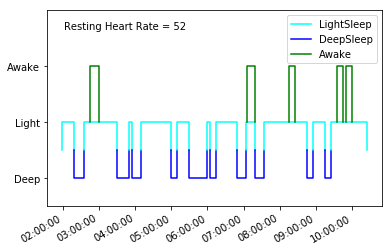

In [13]:
fig, ax = plt.subplots()
for idx in range(sleep_record.ncycles):
    start = sleep_record.cycle_start[idx]
    end = sleep_record.cycle_end[idx]
    x = [start, start, end, end]
    scode = sleep_record.stage_code[idx]
    
    if sleep_record.stage[idx] == 'LightSleep':
        y = [1.5, scode, scode, 1.5]
        c = 'cyan'
    elif sleep_record.stage[idx] == 'DeepSleep':
        y = [1.5, scode, scode, 1.5]
        c = 'blue'
    elif sleep_record.stage[idx] == 'Awake':
        y = [2, scode, scode, 2]
        c = 'green'
    ax.plot(x, y, color=c)
ax.plot([],[], c='cyan', label='LightSleep')
ax.plot([],[], c='blue', label='DeepSleep')
ax.plot([],[], c='green', label='Awake')
ax.legend(loc=1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.autofmt_xdate()
ax.set_ylim(0.5, 4)
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Deep', 'Light', 'Awake'])
ax.text(0.05, 0.9, 'Resting Heart Rate = {0}'.format(int(rHR_p5)), transform=ax.transAxes)
plt.savefig('examples/example_sleep_record.png', bbox_inches='tight')

# Lets iterate through the file now

In [14]:
fl_nLines = len(sa_file_as_list)
fl_nLines

287

In [60]:
idx = 0
RestingHR = []
RestingHRp5 = []
hr_date = np.array([], dtype='datetime64')
while idx < fl_nLines:
    if 'Id' in sa_file_as_list[idx]:
        split_record = us.split_sleepasandroid_record(sa_file_as_list, idx)
        if split_record:
            if split_record.heart_rate:
                heartRateData = np.array(split_record.heart_rate)
                heartRateData = np.array(heartRateData[:].T[2], dtype=float)
                RestingHRp5.append(int(np.percentile(heartRateData, 5)))
                RestingHR.append(int(heartRateData.min()))
                hr_date = np.append(hr_date, np.datetime64(split_record.start_datetime.to_date_string()))
                #hr_date.append(split_record.start_datetime.to_date_string())
    idx += 1
RestingHRp5 = np.array(RestingHRp5)
RestingHR = np.array(RestingHR)
RestingHRp5_Fit = savgol_filter(RestingHRp5, 11, 3)

C:\ProgramData\Anaconda3\lib\site-packages\pendulum\pendulum.py:483: PendulumDeprecationWarning: The create() helper will no longer exist in version 2.0. Use datetime() instead.
  return cls.create(**actual_parts)
C:\Repositories_C\pyhealth\utils_sleepasandroid.py:125: UserWarning: unrecognized event: ['TRACKING_PAUSED', '1523190791842']
  warnings.warn("unrecognized event: {0}".format(event))
C:\Repositories_C\pyhealth\utils_sleepasandroid.py:125: UserWarning: unrecognized event: ['TRACKING_RESUMED', '1523191215307']
  warnings.warn("unrecognized event: {0}".format(event))
C:\Repositories_C\pyhealth\utils_sleepasandroid.py:67: UserWarning: manual entry found, unable to parse sleep data
  warnings.warn('manual entry found, unable to parse '
C:\Repositories_C\pyhealth\utils_sleepasandroid.py:125: UserWarning: unrecognized event: ['LOW_BATTERY', '1518789353255']
  warnings.warn("unrecognized event: {0}".format(event))
C:\Repositories_C\pyhealth\utils_sleepasandroid.py:125: UserWarning: u

In [39]:
# What days did I collect heart rate data from?
hr_date

array(['2018-05-19', '2018-05-18', '2018-05-17', '2018-05-16',
       '2018-05-15', '2018-05-14', '2018-05-13', '2018-05-11',
       '2018-05-09', '2018-05-08', '2018-05-07', '2018-05-06',
       '2018-05-05', '2018-05-04', '2018-05-03', '2018-05-02',
       '2018-05-01', '2018-04-30', '2018-04-29', '2018-04-28',
       '2018-04-27', '2018-04-26', '2018-04-25', '2018-04-24',
       '2018-04-22', '2018-04-21', '2018-04-20', '2018-04-19',
       '2018-04-18', '2018-04-16', '2018-04-15', '2018-04-14',
       '2018-04-13', '2018-04-12', '2018-04-11', '2018-04-10',
       '2018-04-09', '2018-04-08', '2018-04-07', '2018-04-06',
       '2018-04-05', '2018-04-04', '2018-04-03', '2018-04-01',
       '2018-03-31', '2018-03-29', '2018-03-28', '2018-03-27',
       '2018-03-26', '2018-03-25', '2018-03-24', '2018-03-23',
       '2018-03-22', '2018-03-21', '2018-03-19', '2018-03-18',
       '2018-03-17', '2018-03-16', '2018-03-15', '2018-03-12',
       '2018-03-11', '2018-03-10', '2018-03-09', '2018-

## Plot the resting heart data 

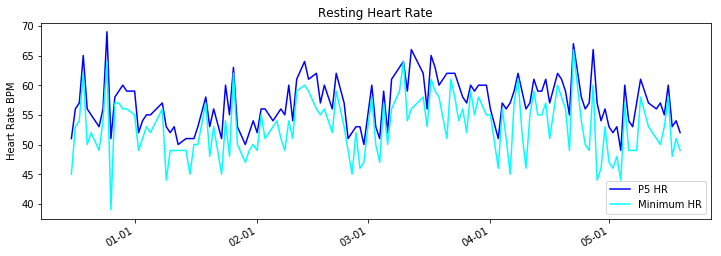

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot_date(hr_date, RestingHRp5, 'blue', label='P5 HR')
ax.plot_date(hr_date, RestingHR, 'cyan', label='Minimum HR')
ax.set_title('Resting Heart Rate')
ax.set_ylabel('Heart Rate BPM')
ax.legend(loc=4)
#ax.format_xdata = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
fig.autofmt_xdate()
plt.savefig('examples/example_resting_heartrate.png', bbox_inches='tight')

In [53]:
yhat_05 = savgol_filter(RestingHRp5, 11, 3)
len(yhat_05)

132

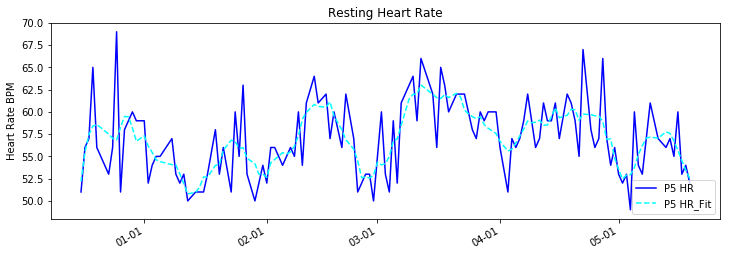

In [61]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot_date(hr_date, RestingHRp5, 'blue', label='P5 HR')
ax.plot_date(hr_date, RestingHRp5_Fit, 'cyan', label='P5 HR_Fit', linestyle='--')
ax.set_title('Resting Heart Rate')
ax.set_ylabel('Heart Rate BPM')
ax.legend(loc=4)
#ax.format_xdata = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
fig.autofmt_xdate()
plt.savefig('examples/example_resting_heartrate.png', bbox_inches='tight')

# Plot Just a range of the Resting HR data

In [63]:
date_start = np.datetime64('2018-05-19')
date_end = np.datetime64('2018-03-19')
hr_idx = []
for i in range(len(hr_date)):
    if hr_date[i] <= date_start and hr_date[i] >= date_end:
        hr_idx.append(i)
hr_idx = np.array(hr_idx, dtype=int)
hr_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54])

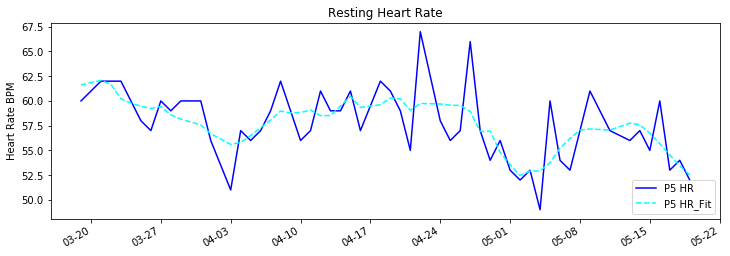

In [64]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot_date(hr_date[hr_idx], RestingHRp5[hr_idx], 'blue', label='P5 HR')
ax.plot_date(hr_date[hr_idx], RestingHRp5_Fit[hr_idx], 'cyan', label='P5 HR_Fit', linestyle='--')
#ax.plot_date(hr_date, RestingHR, 'cyan', label='Minimum HR')
ax.set_title('Resting Heart Rate')
ax.set_ylabel('Heart Rate BPM')
ax.legend(loc=4)
#ax.format_xdata = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
fig.autofmt_xdate()
plt.savefig('examples/example_resting_heartrate.png', bbox_inches='tight')